## 简介

比赛涨分无非是：模型、特征、数据，这题的特征做起来收益太少（也可能我没找到），模型lgb已经很不错了，数据方面，剩下的就是尽量减少噪音的基础上好好利用测试集+两张表的数据了。

有部分人说无法复现到0.89，所以我把代码放出来，“YB统计人工智能”分享的884的代码，之所以涨分，我发现还有一个重要原因就是增加了噪音较少的训练样本，所以这题把测试集做成伪标签也加入训练，当然也要限定阈值0.5，小于0.5的以0标签放入，其余的不放入。同理把“YB统计人工智能”分享的884的代码的阈值也改成0.5，也就是增加了internet+测试集的少噪音数据



第一步：下载比赛数据，train_public.csv、submit_example.csv、test_public.csv、train_internet.csv，

新建文件夹raw_data，并把上面的csv文件放到这个文件夹里，运行下面的代码（这个代码完全是复制“YB统计人工智能”分享的884的代码）

## 总结

使用了扩充训练集的方式提高了训练效果

## 第一部分

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import re
import pandas as pd
import lightgbm as lgb
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from sklearn.model_selection import StratifiedKFold
from dateutil.relativedelta import relativedelta

In [2]:
train_data = pd.read_csv('datasets/train_public.csv')
submit_example = pd.read_csv('datasets/submit_example.csv')
test_public = pd.read_csv('datasets/test_public.csv')
train_inte = pd.read_csv('datasets/train_internet.csv')

pd.set_option('max_columns', None)
pd.set_option('max_rows', 200)
pd.set_option('float_format', lambda x: '%.3f' % x)

In [3]:
# 训练模型
def train_model(data_, test_, y_, folds_):
    oof_preds = np.zeros(data_.shape[0])
    sub_preds = np.zeros(test_.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in data_.columns if f not in ['loan_id', 'user_id', 'isDefault'] ]
    for n_fold, (trn_idx, val_idx) in enumerate(folds_.split(data_)):
        trn_x, trn_y = data_[feats].iloc[trn_idx], y_.iloc[trn_idx]
        val_x, val_y = data_[feats].iloc[val_idx], y_.iloc[val_idx]
        clf = LGBMClassifier(
            n_estimators=4000,
            learning_rate=0.08,
            num_leaves=2**5,
            colsample_bytree=.65,
            subsample=.9,
            max_depth=5,
#             max_bin=250,
            reg_alpha=.3,
            reg_lambda=.3,
            min_split_gain=.01,
            min_child_weight=2,
            silent=-1,
            verbose=-1,
        )
        
        clf.fit(trn_x, trn_y, 
                eval_set= [(trn_x, trn_y), (val_x, val_y)], 
                eval_metric='auc', verbose=100, early_stopping_rounds=40  #30
               )

        oof_preds[val_idx] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_[feats], num_iteration=clf.best_iteration_)[:, 1] / folds_.n_splits
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx])))
        del clf, trn_x, trn_y, val_x, val_y
        gc.collect()
        
    print('Full AUC score %.6f' % roc_auc_score(y, oof_preds)) 
    
    test_['isDefault'] = sub_preds

    return oof_preds, test_[['loan_id', 'isDefault']], feature_importance_df

# 特征重要性
def display_importances(feature_importance_df_):
    # Plot feature importances
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:50].index
    
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    
    plt.figure(figsize=(8,10))
    sns.barplot(x="importance", y="feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances.png')

In [4]:
# 工作年限字典转换
def workYearDIc(x):
    if str(x)=='nan':
        return -1
    x = x.replace('< 1','0')
    return int(re.search('(\d+)', x).group())

# 字段处理
def findDig(val):
    fd = re.search('(\d+-)', val)
    if fd is None:
        return '1-'+val
    return val + '-01'

# 等级字典转换
class_dict = {
    'A': 1,
    'B': 2,
    'C': 3,
    'D': 4,
    'E': 5,
    'F': 6,
    'G': 7,
}

In [5]:
# 特征字段处理
timeMax = pd.to_datetime('1-Dec-21')
train_data['work_year'] = train_data['work_year'].map(workYearDIc)
test_public['work_year'] = test_public['work_year'].map(workYearDIc)
train_data['class'] = train_data['class'].map(class_dict)
test_public['class'] = test_public['class'].map(class_dict)

train_data['earlies_credit_mon'] = pd.to_datetime(train_data['earlies_credit_mon'].map(findDig))
test_public['earlies_credit_mon'] = pd.to_datetime(test_public['earlies_credit_mon'].map(findDig))
train_data.loc[ train_data['earlies_credit_mon']>timeMax,'earlies_credit_mon' ] = train_data.loc[ train_data['earlies_credit_mon']>timeMax,'earlies_credit_mon' ]+  pd.offsets.DateOffset(years=-100)  
test_public.loc[ test_public['earlies_credit_mon']>timeMax,'earlies_credit_mon' ] = test_public.loc[ test_public['earlies_credit_mon']>timeMax,'earlies_credit_mon' ]+ pd.offsets.DateOffset(years=-100)
train_data['issue_date'] = pd.to_datetime(train_data['issue_date'])
test_public['issue_date'] = pd.to_datetime(test_public['issue_date'])



#Internet数据处理
train_inte['work_year'] = train_inte['work_year'].map(workYearDIc)
train_inte['class'] = train_inte['class'].map(class_dict)
train_inte['earlies_credit_mon'] = pd.to_datetime(train_inte['earlies_credit_mon'])
train_inte['issue_date'] = pd.to_datetime(train_inte['issue_date'])


train_data['issue_date_month'] = train_data['issue_date'].dt.month
test_public['issue_date_month'] = test_public['issue_date'].dt.month
train_data['issue_date_dayofweek'] = train_data['issue_date'].dt.dayofweek
test_public['issue_date_dayofweek'] = test_public['issue_date'].dt.dayofweek

train_data['earliesCreditMon'] = train_data['earlies_credit_mon'].dt.month
test_public['earliesCreditMon'] = test_public['earlies_credit_mon'].dt.month
train_data['earliesCreditYear'] = train_data['earlies_credit_mon'].dt.year
test_public['earliesCreditYear'] = test_public['earlies_credit_mon'].dt.year


###internet数据

train_inte['issue_date_month'] = train_inte['issue_date'].dt.month
train_inte['issue_date_dayofweek'] = train_inte['issue_date'].dt.dayofweek
train_inte['earliesCreditMon'] = train_inte['earlies_credit_mon'].dt.month
train_inte['earliesCreditYear'] = train_inte['earlies_credit_mon'].dt.year

In [6]:
train_inte

,loan_id,user_id,total_loan,year_of_loan,interest,monthly_payment,class,sub_class,work_type,employer_type,industry,work_year,house_exist,house_loan_status,censor_status,marriage,offsprings,issue_date,use,post_code,region,debt_loan_ratio,del_in_18month,scoring_low,scoring_high,pub_dero_bankrup,early_return,early_return_amount,early_return_amount_3mon,recircle_b,recircle_u,initial_list_status,earlies_credit_mon,title,policy_code,f0,f1,f2,f3,f4,f5,is_default,issue_date_month,issue_date_dayofweek,earliesCreditMon,earliesCreditYear
0,119262,0,12000.000,5,11.530,264.100,2,B5,职员,普通企业,采矿业,-1,0,0,2,0,0,2015-06-01,0,814.000,4,5.070,1.000,670.000,674.000,1.000,0,0,0.000,3855.000,23.100,0,1984-03-01,0.000,1.000,1.000,0.000,8.000,17.000,8.000,1.000,1,6,0,3,1984
1,369815,1,8000.000,3,13.980,273.350,3,C3,其他,普通企业,国际组织,10,0,1,2,1,3,2010-10-01,2,240.000,21,15.040,0.000,725.000,729.000,0.000,0,0,0.000,118632.000,99.900,1,1992-01-01,94.000,1.000,NaN,NaN,NaN,NaN,NaN,NaN,0,10,4,1,1992
2,787833,2,20000.000,5,17.990,507.760,4,D2,工人,上市企业,信息传输、软件和信息技术服务业,10,0,0,1,0,0,2016-08-01,0,164.000,20,17.380,1.000,675.000,679.000,0.000,0,0,0.000,15670.000,72.500,0,1996-10-01,0.000,1.000,6.000,0.000,10.000,8.000,3.000,0.000,0,8,0,10,1996
3,671675,3,10700.000,3,10.160,346.070,2,B1,职员,普通企业,电力、热力生产供应业,2,2,0,2,0,0,2013-05-01,4,48.000,10,27.870,0.000,710.000,714.000,0.000,0,0,0.000,18859.000,78.600,0,2000-07-01,41646.000,1.000,3.000,0.000,4.000,11.000,6.000,0.000,0,5,2,7,2000
4,245160,4,8000.000,3,8.240,251.580,2,B1,其他,政府机构,金融业,5,1,2,0,0,0,2017-04-01,4,122.000,9,3.470,0.000,660.000,664.000,0.000,0,0,0.000,8337.000,67.800,1,2000-03-01,4.000,1.000,3.000,0.000,8.000,6.000,4.000,1.000,0,4,5,3,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,624287,749995,12000.000,3,11.470,395.550,2,B5,职员,上市企业,文化和体育业,4,0,0,1,0,0,2016-02-01,0,95.000,13,21.550,0.000,665.000,669.000,0.000,0,0,0.000,9572.000,62.200,0,1995-06-01,0.000,1.000,6.000,0.000,8.000,22.000,12.000,5.000,0,2,0,6,1995
749996,427602,749996,12000.000,3,6.030,365.230,1,A1,工人,政府机构,住宿和餐饮业,8,1,0,2,0,0,2014-03-01,4,74.000,30,4.520,0.000,770.000,774.000,0.000,6,810,352.902,14183.000,30.500,1,2001-09-01,4.000,1.000,2.000,0.000,7.000,4.000,4.000,0.000,0,3,5,9,2001
749997,206828,749997,10000.000,3,15.410,348.670,4,D1,职员,政府机构,住宿和餐饮业,8,1,2,2,1,0,2015-12-01,7,74.000,30,17.250,0.000,665.000,669.000,0.000,0,0,0.000,9259.000,72.900,0,2008-10-01,8.000,1.000,6.000,0.000,10.000,11.000,3.000,0.000,0,12,1,10,2008
749998,293912,749998,7200.000,3,9.440,230.440,2,B1,其他,政府机构,信息传输、软件和信息技术服务业,10,2,0,2,3,2,2017-12-01,0,134.000,8,24.850,0.000,675.000,679.000,1.000,0,0,0.000,9825.000,71.200,0,2006-04-01,0.000,1.000,7.000,0.000,9.000,11.000,6.000,0.000,0,12,4,4,2006


In [7]:
cat_cols = ['employer_type', 'industry']

from sklearn.preprocessing import LabelEncoder
for col in cat_cols:
    lbl = LabelEncoder().fit(train_data[col])
    train_data[col] = lbl.transform(train_data[col])
    test_public[col] = lbl.transform(test_public[col])
    
    #Internet处理
    train_inte[col] = lbl.transform(train_inte[col])
    
# 'f1','policy_code','app_type' 这三个去掉是881
# ,'f1','policy_code','app_type'
col_to_drop = ['issue_date', 'earlies_credit_mon']
train_data = train_data.drop(col_to_drop, axis=1)
test_public = test_public.drop(col_to_drop, axis=1 )

##internet处理
train_inte = train_inte.drop(col_to_drop, axis=1 )
# 暂时不变
# train_inte = train_inte.rename(columns={'is_default':'isDefault'})
# data = pd.concat( [train_data,test_public] )
tr_cols = set(train_data.columns)
same_col = list(tr_cols.intersection(set(train_inte.columns)))
train_inteSame = train_inte[same_col].copy()

Inte_add_cos = list(tr_cols.difference(set(same_col)))
for col in Inte_add_cos:
    train_inteSame[col] = np.nan

#81后加 
# for col in cat_cols:
#     dum = pd.get_dummies(data[col], prefix='OneHot_'+col +'_')
#     data = pd.concat([data, dum], axis=1)
# #     del data[col]
#     del dum

y = train_data['isDefault']
folds = KFold(n_splits=5, shuffle=True, random_state=546789)
oof_preds, IntePre, importances = train_model(train_data, train_inteSame, y, folds)

IntePre['isDef'] = train_inte['is_default']

Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[58]	training's auc: 0.933523	training's binary_logloss: 0.249533	valid_1's auc: 0.892153	valid_1's binary_logloss: 0.290676
Fold  1 AUC : 0.892153
Training until validation scores don't improve for 40 rounds
[100]	training's auc: 0.954902	training's binary_logloss: 0.224771	valid_1's auc: 0.888907	valid_1's binary_logloss: 0.289767
Early stopping, best iteration is:
[64]	training's auc: 0.937329	training's binary_logloss: 0.246772	valid_1's auc: 0.891066	valid_1's binary_logloss: 0.28752
Fold  2 AUC : 0.891066
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[47]	training's auc: 0.93133	training's binary_logloss: 0.2514	valid_1's auc: 0.875276	valid_1's binary_logloss: 0.31178
Fold  3 AUC : 0.875276
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[54]	training's auc: 0.937112	training's binary_log

G:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [8]:
IntePre

,loan_id,isDefault,isDef
0,119262,0.281,1
1,369815,0.326,0
2,787833,0.437,0
3,671675,0.366,0
4,245160,0.210,0
...,...,...,...
749995,624287,0.244,0
749996,427602,0.009,0
749997,206828,0.348,0
749998,293912,0.311,0


In [9]:
from sklearn.metrics import roc_auc_score

roc_auc_score(IntePre['isDef'],IntePre.isDefault)
## 选择阈值0.05，从internet表中提取预测小于该概率的样本，并对不同来源的样本赋予来源值
InteId = IntePre.loc[IntePre.isDefault<0.05, 'loan_id'].tolist()

train_data['dataSourse'] = 1
test_public['dataSourse'] = 1
train_inteSame['dataSourse'] = 0
train_inteSame['isDefault'] = train_inte['is_default']
use_te = train_inteSame[train_inteSame.loan_id.isin( InteId )].copy()
data = pd.concat([ train_data,test_public,use_te]).reset_index(drop=True)


G:\anaconda3\envs\py37\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


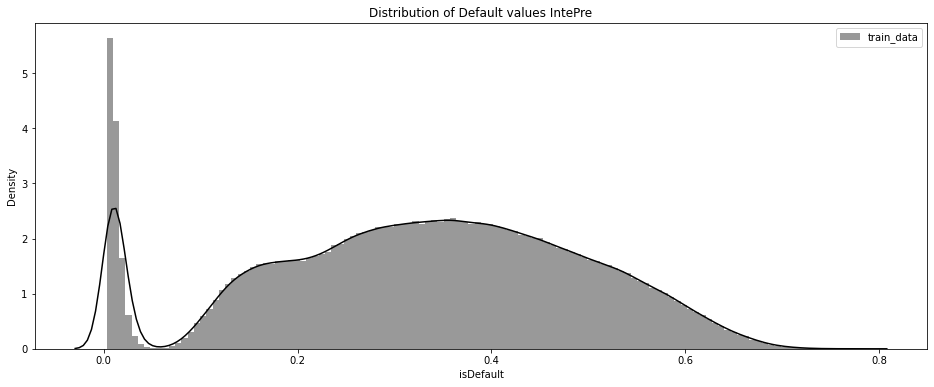

In [10]:
# InteId = IntePre.loc[IntePre.isDefault<0.05, 'loan_id'].tolist()
# train_inte = train_inte.rename(columns={'is_default':'isDefault'})

# train_data['dataSourse'] = 1
# test_public['dataSourse'] = 1
# train_inte['dataSourse'] = 0



# use_te = train_inte[train_inte.loan_id.isin( InteId )].copy()
# data = pd.concat([ train_data,test_public,use_te]).reset_index(drop=True)

# IntePre.isDefault
plt.figure(figsize=(16,6))
plt.title("Distribution of Default values IntePre")
sns.distplot(IntePre['isDefault'],color="black", kde=True,bins=120, label='train_data')
# sns.distplot(train_inte[col],color="red", kde=True,bins=120, label='train_inte')
plt.legend();plt.show()
train = data[data['isDefault'].notna()]
test  = data[data['isDefault'].isna()]
# for col in ['sub_class', 'work_type']:
#     del train[col]
#     del test[col]


del data
del train_data,test_public

In [11]:
y = train['isDefault']
folds = KFold(n_splits=5, shuffle=True, random_state=546789)
oof_preds, test_preds, importances = train_model(train, test, y, folds)
test_preds.rename({'loan_id': 'id'}, axis=1)[['id', 'isDefault']].to_csv('nn2.csv', index=False)

Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[53]	training's auc: 0.990736	training's binary_logloss: 0.0367915	valid_1's auc: 0.986415	valid_1's binary_logloss: 0.0447263
Fold  1 AUC : 0.986415
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[34]	training's auc: 0.989731	training's binary_logloss: 0.0402431	valid_1's auc: 0.98474	valid_1's binary_logloss: 0.0438985
Fold  2 AUC : 0.984740
Training until validation scores don't improve for 40 rounds
[100]	training's auc: 0.992613	training's binary_logloss: 0.0346112	valid_1's auc: 0.986311	valid_1's binary_logloss: 0.0421044
Early stopping, best iteration is:
[88]	training's auc: 0.99166	training's binary_logloss: 0.0358044	valid_1's auc: 0.986573	valid_1's binary_logloss: 0.0418367
Fold  3 AUC : 0.986573
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[35]	training's auc: 0.989772	training's

## 第二部分

In [12]:
import pandas as pd
train_data = pd.read_csv('datasets/train_public.csv')
test_data = pd.read_csv('datasets/test_public.csv')
sub=pd.read_csv("nn2.csv")
sub=sub.rename(columns={'id': 'loan_id'})
sub.loc[sub['isDefault']<0.5,'isDefault'] = 0
nw_sub=sub[(sub['isDefault']==0)]
nw_test_data=test_data.merge(nw_sub,on='loan_id',how='inner')
nw_train_data = pd.concat([train_data,nw_test_data]).reset_index(drop=True)
nw_train_data.to_csv("datasets/nw_train_public.csv",index=0)

## 第三部分

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import re
import pandas as pd
import lightgbm as lgb
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from sklearn.model_selection import StratifiedKFold
from dateutil.relativedelta import relativedelta

In [14]:
train_data = pd.read_csv('datasets/nw_train_public.csv')
submit_example = pd.read_csv('datasets/submit_example.csv')
test_public = pd.read_csv('datasets/test_public.csv')
train_inte = pd.read_csv('datasets/train_internet.csv')

pd.set_option('max_columns', None)
pd.set_option('max_rows', 200)
pd.set_option('float_format', lambda x: '%.3f' % x)

In [15]:
def train_model(data_, test_, y_, folds_):
    oof_preds = np.zeros(data_.shape[0])
    sub_preds = np.zeros(test_.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in data_.columns if f not in ['loan_id', 'user_id', 'isDefault'] ]
    for n_fold, (trn_idx, val_idx) in enumerate(folds_.split(data_)):
        trn_x, trn_y = data_[feats].iloc[trn_idx], y_.iloc[trn_idx]
        val_x, val_y = data_[feats].iloc[val_idx], y_.iloc[val_idx]
        clf = LGBMClassifier(
            n_estimators=4000,
            learning_rate=0.08,
            num_leaves=2**5,
            colsample_bytree=.65,
            subsample=.9,
            max_depth=5,
#             max_bin=250,
            reg_alpha=.3,
            reg_lambda=.3,
            min_split_gain=.01,
            min_child_weight=2,
            silent=-1,
            verbose=-1,
        )
        
        clf.fit(trn_x, trn_y, 
                eval_set= [(trn_x, trn_y), (val_x, val_y)], 
                eval_metric='auc', verbose=100, early_stopping_rounds=40  #30
               )

        oof_preds[val_idx] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_[feats], num_iteration=clf.best_iteration_)[:, 1] / folds_.n_splits
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx])))
        del clf, trn_x, trn_y, val_x, val_y
        gc.collect()
        
    print('Full AUC score %.6f' % roc_auc_score(y, oof_preds)) 
    
    test_['isDefault'] = sub_preds

    return oof_preds, test_[['loan_id', 'isDefault']], feature_importance_df
    
def display_importances(feature_importance_df_):
    # Plot feature importances
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:50].index
    
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    
    plt.figure(figsize=(8,10))
    sns.barplot(x="importance", y="feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances.png')


In [16]:
def workYearDIc(x):
    if str(x)=='nan':
        return -1
    x = x.replace('< 1','0')
    return int(re.search('(\d+)', x).group())

def findDig(val):
    fd = re.search('(\d+-)', val)
    if fd is None:
        return '1-'+val
    return val + '-01'


class_dict = {
    'A': 1,
    'B': 2,
    'C': 3,
    'D': 4,
    'E': 5,
    'F': 6,
    'G': 7,
}

timeMax = pd.to_datetime('1-Dec-21')
train_data['work_year'] = train_data['work_year'].map(workYearDIc)
test_public['work_year'] = test_public['work_year'].map(workYearDIc)
train_data['class'] = train_data['class'].map(class_dict)
test_public['class'] = test_public['class'].map(class_dict)

train_data['earlies_credit_mon'] = pd.to_datetime(train_data['earlies_credit_mon'].map(findDig))
test_public['earlies_credit_mon'] = pd.to_datetime(test_public['earlies_credit_mon'].map(findDig))
train_data.loc[ train_data['earlies_credit_mon']>timeMax,'earlies_credit_mon' ] = train_data.loc[ train_data['earlies_credit_mon']>timeMax,'earlies_credit_mon' ]+  pd.offsets.DateOffset(years=-100)  
test_public.loc[ test_public['earlies_credit_mon']>timeMax,'earlies_credit_mon' ] = test_public.loc[ test_public['earlies_credit_mon']>timeMax,'earlies_credit_mon' ]+ pd.offsets.DateOffset(years=-100)
train_data['issue_date'] = pd.to_datetime(train_data['issue_date'])
test_public['issue_date'] = pd.to_datetime(test_public['issue_date'])



#Internet数据处理
train_inte['work_year'] = train_inte['work_year'].map(workYearDIc)
train_inte['class'] = train_inte['class'].map(class_dict)
train_inte['earlies_credit_mon'] = pd.to_datetime(train_inte['earlies_credit_mon'])
train_inte['issue_date'] = pd.to_datetime(train_inte['issue_date'])


train_data['issue_date_month'] = train_data['issue_date'].dt.month
test_public['issue_date_month'] = test_public['issue_date'].dt.month
train_data['issue_date_dayofweek'] = train_data['issue_date'].dt.dayofweek
test_public['issue_date_dayofweek'] = test_public['issue_date'].dt.dayofweek

train_data['earliesCreditMon'] = train_data['earlies_credit_mon'].dt.month
test_public['earliesCreditMon'] = test_public['earlies_credit_mon'].dt.month
train_data['earliesCreditYear'] = train_data['earlies_credit_mon'].dt.year
test_public['earliesCreditYear'] = test_public['earlies_credit_mon'].dt.year


###internet数据

train_inte['issue_date_month'] = train_inte['issue_date'].dt.month
train_inte['issue_date_dayofweek'] = train_inte['issue_date'].dt.dayofweek
train_inte['earliesCreditMon'] = train_inte['earlies_credit_mon'].dt.month
train_inte['earliesCreditYear'] = train_inte['earlies_credit_mon'].dt.year



In [17]:
test_public

,loan_id,user_id,total_loan,year_of_loan,interest,monthly_payment,class,employer_type,industry,work_year,house_exist,censor_status,issue_date,use,post_code,region,debt_loan_ratio,del_in_18month,scoring_low,scoring_high,known_outstanding_loan,known_dero,pub_dero_bankrup,recircle_b,recircle_u,initial_list_status,app_type,earlies_credit_mon,title,policy_code,f0,f1,f2,f3,f4,early_return,early_return_amount,early_return_amount_3mon,issue_date_month,issue_date_dayofweek,earliesCreditMon,earliesCreditYear
0,1000575,200575,2890.909,3,10.791,88.010,2,幼教与中小学校,住宿和餐饮业,5,0,1,2017-12-01,0,314,0,23.040,0,745.000,869.167,7,0,0.000,8647.692,31.846,1,0,2001-03-03,0,1,2.000,0.000,15.000,5.000,4.000,3,773,89.192,12,4,3,2001
1,1028125,228125,7272.727,3,9.990,258.100,2,普通企业,批发和零售业,10,1,1,2015-07-01,5,29,19,27.755,0,681.818,738.636,24,0,0.000,9406.154,18.277,0,0,1999-12-01,6,1,8.000,0.000,8.000,29.000,14.000,1,1894,218.538,7,2,12,1999
2,1010694,210694,26295.455,3,15.763,764.030,3,普通企业,住宿和餐饮业,10,0,2,2013-04-01,0,488,24,25.495,1,758.182,947.727,11,0,0.000,26414.769,62.300,1,0,1999-04-01,268,1,6.000,0.000,4.000,10.000,6.000,1,5670,1221.231,4,0,4,1999
3,1026712,226712,22690.909,5,19.305,524.300,4,普通企业,采矿业,10,0,2,2017-12-01,0,489,30,10.620,0,572.727,620.455,8,0,0.000,1198.000,7.700,0,0,2000-07-01,0,1,4.000,0.000,12.000,10.000,8.000,2,4800,443.077,12,4,7,2000
4,1002895,202895,14545.455,3,7.139,490.320,1,世界五百强,金融业,1,0,0,2016-06-01,2,418,45,6.611,0,638.182,691.364,15,0,0.000,3920.000,8.831,1,0,2001-05-07,5,1,4.000,0.000,7.000,14.000,9.000,0,3516,649.108,6,2,5,2001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,1008856,208856,9454.545,5,12.015,183.470,3,政府机构,信息传输、软件和信息技术服务业,0,1,0,2011-01-01,0,48,10,14.900,0,568.636,710.795,11,0,0.000,5370.462,75.785,1,0,2001-07-05,10595,1,NaN,NaN,NaN,NaN,NaN,0,0,0.000,1,5,7,2001
4996,1016651,216651,5500.000,3,7.970,172.280,1,政府机构,房地产业,5,1,0,2017-05-01,0,31,2,12.160,0,796.364,995.455,5,0,0.000,6326.538,43.077,0,0,2001-04-12,0,1,3.000,0.000,2.000,5.000,3.000,3,1564,0.000,5,0,4,2001
4997,1024140,224140,30545.455,3,8.900,889.090,1,上市企业,房地产业,10,0,2,2013-12-01,0,464,37,21.550,0,710.000,769.167,17,0,0.000,63903.692,79.385,0,0,1986-10-01,21735,1,8.000,0.000,17.000,20.000,14.000,2,5456,1510.892,12,6,10,1986
4998,1014316,214316,4090.909,3,6.030,152.180,1,政府机构,文化和体育业,10,0,2,2012-09-01,0,566,30,13.222,0,709.091,768.182,7,0,0.000,2703.692,29.423,1,0,1999-03-01,24272,1,1.000,0.000,6.000,10.000,10.000,3,223,41.169,9,5,3,1999


In [18]:
cat_cols = ['employer_type', 'industry']

from sklearn.preprocessing import LabelEncoder
for col in cat_cols:
    lbl = LabelEncoder().fit(train_data[col])
    train_data[col] = lbl.transform(train_data[col])
    test_public[col] = lbl.transform(test_public[col])
    
    #Internet处理
    train_inte[col] = lbl.transform(train_inte[col])
    
# 'f1','policy_code','app_type' 这三个去掉是881
# ,'f1','policy_code','app_type'
col_to_drop = ['issue_date', 'earlies_credit_mon']
train_data = train_data.drop(col_to_drop, axis=1)
test_public = test_public.drop(col_to_drop, axis=1 )

##internet处理
train_inte = train_inte.drop(col_to_drop, axis=1 )
# 暂时不变
# train_inte = train_inte.rename(columns={'is_default':'isDefault'})
# data = pd.concat( [train_data,test_public] )
tr_cols = set(train_data.columns)
same_col = list(tr_cols.intersection(set(train_inte.columns)))
train_inteSame = train_inte[same_col].copy()

Inte_add_cos = list(tr_cols.difference(set(same_col)))
for col in Inte_add_cos:
    train_inteSame[col] = np.nan

#81后加 
# for col in cat_cols:
#     dum = pd.get_dummies(data[col], prefix='OneHot_'+col +'_')
#     data = pd.concat([data, dum], axis=1)
# #     del data[col]
#     del dum


In [19]:
test_public

,loan_id,user_id,total_loan,year_of_loan,interest,monthly_payment,class,employer_type,industry,work_year,house_exist,censor_status,use,post_code,region,debt_loan_ratio,del_in_18month,scoring_low,scoring_high,known_outstanding_loan,known_dero,pub_dero_bankrup,recircle_b,recircle_u,initial_list_status,app_type,title,policy_code,f0,f1,f2,f3,f4,early_return,early_return_amount,early_return_amount_3mon,issue_date_month,issue_date_dayofweek,earliesCreditMon,earliesCreditYear
0,1000575,200575,2890.909,3,10.791,88.010,2,2,1,5,0,1,0,314,0,23.040,0,745.000,869.167,7,0,0.000,8647.692,31.846,1,0,0,1,2.000,0.000,15.000,5.000,4.000,3,773,89.192,12,4,3,2001
1,1028125,228125,7272.727,3,9.990,258.100,2,4,9,10,1,1,5,29,19,27.755,0,681.818,738.636,24,0,0.000,9406.154,18.277,0,0,6,1,8.000,0.000,8.000,29.000,14.000,1,1894,218.538,7,2,12,1999
2,1010694,210694,26295.455,3,15.763,764.030,3,4,1,10,0,2,0,488,24,25.495,1,758.182,947.727,11,0,0.000,26414.769,62.300,1,0,268,1,6.000,0.000,4.000,10.000,6.000,1,5670,1221.231,4,0,4,1999
3,1026712,226712,22690.909,5,19.305,524.300,4,4,12,10,0,2,0,489,30,10.620,0,572.727,620.455,8,0,0.000,1198.000,7.700,0,0,0,1,4.000,0.000,12.000,10.000,8.000,2,4800,443.077,12,4,7,2000
4,1002895,202895,14545.455,3,7.139,490.320,1,1,13,1,0,0,2,418,45,6.611,0,638.182,691.364,15,0,0.000,3920.000,8.831,1,0,5,1,4.000,0.000,7.000,14.000,9.000,0,3516,649.108,6,2,5,2001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,1008856,208856,9454.545,5,12.015,183.470,3,3,2,0,1,0,0,48,10,14.900,0,568.636,710.795,11,0,0.000,5370.462,75.785,1,0,10595,1,NaN,NaN,NaN,NaN,NaN,0,0,0.000,1,5,7,2001
4996,1016651,216651,5500.000,3,7.970,172.280,1,3,8,5,1,0,0,31,2,12.160,0,796.364,995.455,5,0,0.000,6326.538,43.077,0,0,0,1,3.000,0.000,2.000,5.000,3.000,3,1564,0.000,5,0,4,2001
4997,1024140,224140,30545.455,3,8.900,889.090,1,0,8,10,0,2,0,464,37,21.550,0,710.000,769.167,17,0,0.000,63903.692,79.385,0,0,21735,1,8.000,0.000,17.000,20.000,14.000,2,5456,1510.892,12,6,10,1986
4998,1014316,214316,4090.909,3,6.030,152.180,1,3,10,10,0,2,0,566,30,13.222,0,709.091,768.182,7,0,0.000,2703.692,29.423,1,0,24272,1,1.000,0.000,6.000,10.000,10.000,3,223,41.169,9,5,3,1999


Training until validation scores don't improve for 40 rounds
[100]	training's auc: 0.954537	training's binary_logloss: 0.181663	valid_1's auc: 0.906575	valid_1's binary_logloss: 0.227737
Early stopping, best iteration is:
[72]	training's auc: 0.942137	training's binary_logloss: 0.194477	valid_1's auc: 0.907604	valid_1's binary_logloss: 0.226796
Fold  1 AUC : 0.907604
Training until validation scores don't improve for 40 rounds
[100]	training's auc: 0.955247	training's binary_logloss: 0.178987	valid_1's auc: 0.894962	valid_1's binary_logloss: 0.237964
Early stopping, best iteration is:
[75]	training's auc: 0.945259	training's binary_logloss: 0.189734	valid_1's auc: 0.895679	valid_1's binary_logloss: 0.237188
Fold  2 AUC : 0.895679
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[44]	training's auc: 0.930167	training's binary_logloss: 0.208874	valid_1's auc: 0.888311	valid_1's binary_logloss: 0.236471
Fold  3 AUC : 0.888311
Training until v

G:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
G:\anaconda3\envs\py37\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


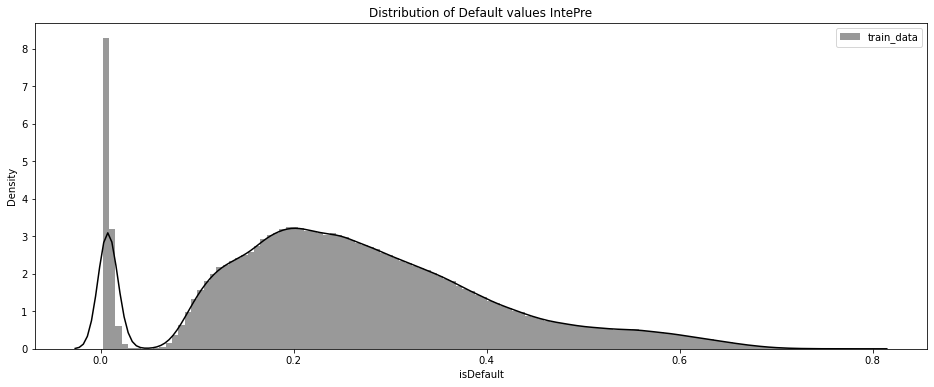

In [20]:
y = train_data['isDefault']
folds = KFold(n_splits=5, shuffle=True, random_state=546789)
oof_preds, IntePre, importances = train_model(train_data, train_inteSame, y, folds)

IntePre['isDef'] = train_inte['is_default']
from sklearn.metrics import roc_auc_score
roc_auc_score(IntePre['isDef'],IntePre.isDefault)
## 选择阈值0.05，从internet表中提取预测小于该概率的样本，并对不同来源的样本赋予来源值
InteId = IntePre.loc[IntePre.isDefault<0.5, 'loan_id'].tolist()

train_data['dataSourse'] = 1
test_public['dataSourse'] = 1
train_inteSame['dataSourse'] = 0
train_inteSame['isDefault'] = train_inte['is_default']
use_te = train_inteSame[train_inteSame.loan_id.isin( InteId )].copy()
data = pd.concat([train_data,test_public,use_te]).reset_index(drop=True)




# InteId = IntePre.loc[IntePre.isDefault<0.05, 'loan_id'].tolist()
# train_inte = train_inte.rename(columns={'is_default':'isDefault'})

# train_data['dataSourse'] = 1
# test_public['dataSourse'] = 1
# train_inte['dataSourse'] = 0



# use_te = train_inte[train_inte.loan_id.isin( InteId )].copy()
# data = pd.concat([ train_data,test_public,use_te]).reset_index(drop=True)

# IntePre.isDefault
plt.figure(figsize=(16,6))
plt.title("Distribution of Default values IntePre")
sns.distplot(IntePre['isDefault'],color="black", kde=True,bins=120, label='train_data')
# sns.distplot(train_inte[col],color="red", kde=True,bins=120, label='train_inte')
plt.legend();plt.show()

# for col in ['sub_class', 'work_type']:
#     del train[col]
#     del test[col]



del train_data,test_public

train_data = data[data['isDefault'].notna()]
test_data = data[data['isDefault'].isna()]

del data

In [23]:
test_data

,loan_id,user_id,total_loan,year_of_loan,interest,monthly_payment,class,employer_type,industry,work_year,house_exist,censor_status,use,post_code,region,debt_loan_ratio,del_in_18month,scoring_low,scoring_high,known_outstanding_loan,known_dero,pub_dero_bankrup,recircle_b,recircle_u,initial_list_status,app_type,title,policy_code,f0,f1,f2,f3,f4,early_return,early_return_amount,early_return_amount_3mon,isDefault,issue_date_month,issue_date_dayofweek,earliesCreditMon,earliesCreditYear,dataSourse
14595,1000575,200575,2890.909,3,10.791,88.010,2,2,1,5,0,1,0,314.000,0,23.040,0.000,745.000,869.167,7.000,0.000,0.000,8647.692,31.846,1,0.000,0.000,1.000,2.000,0.000,15.000,5.000,4.000,3,773,89.192,0.003,12,4,3,2001,1
14596,1028125,228125,7272.727,3,9.990,258.100,2,4,9,10,1,1,5,29.000,19,27.755,0.000,681.818,738.636,24.000,0.000,0.000,9406.154,18.277,0,0.000,6.000,1.000,8.000,0.000,8.000,29.000,14.000,1,1894,218.538,0.029,7,2,12,1999,1
14597,1010694,210694,26295.455,3,15.763,764.030,3,4,1,10,0,2,0,488.000,24,25.495,1.000,758.182,947.727,11.000,0.000,0.000,26414.769,62.300,1,0.000,268.000,1.000,6.000,0.000,4.000,10.000,6.000,1,5670,1221.231,0.001,4,0,4,1999,1
14598,1026712,226712,22690.909,5,19.305,524.300,4,4,12,10,0,2,0,489.000,30,10.620,0.000,572.727,620.455,8.000,0.000,0.000,1198.000,7.700,0,0.000,0.000,1.000,4.000,0.000,12.000,10.000,8.000,2,4800,443.077,0.002,12,4,7,2000,1
14599,1002895,202895,14545.455,3,7.139,490.320,1,1,13,1,0,0,2,418.000,45,6.611,0.000,638.182,691.364,15.000,0.000,0.000,3920.000,8.831,1,0.000,5.000,1.000,4.000,0.000,7.000,14.000,9.000,0,3516,649.108,0.005,6,2,5,2001,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19590,1008856,208856,9454.545,5,12.015,183.470,3,3,2,0,1,0,0,48.000,10,14.900,0.000,568.636,710.795,11.000,0.000,0.000,5370.462,75.785,1,0.000,10595.000,1.000,NaN,NaN,NaN,NaN,NaN,0,0,0.000,0.290,1,5,7,2001,1
19591,1016651,216651,5500.000,3,7.970,172.280,1,3,8,5,1,0,0,31.000,2,12.160,0.000,796.364,995.455,5.000,0.000,0.000,6326.538,43.077,0,0.000,0.000,1.000,3.000,0.000,2.000,5.000,3.000,3,1564,0.000,0.007,5,0,4,2001,1
19592,1024140,224140,30545.455,3,8.900,889.090,1,0,8,10,0,2,0,464.000,37,21.550,0.000,710.000,769.167,17.000,0.000,0.000,63903.692,79.385,0,0.000,21735.000,1.000,8.000,0.000,17.000,20.000,14.000,2,5456,1510.892,0.001,12,6,10,1986,1
19593,1014316,214316,4090.909,3,6.030,152.180,1,3,10,10,0,2,0,566.000,30,13.222,0.000,709.091,768.182,7.000,0.000,0.000,2703.692,29.423,1,0.000,24272.000,1.000,1.000,0.000,6.000,10.000,10.000,3,223,41.169,0.003,9,5,3,1999,1


In [22]:
y = train_data['isDefault']
folds = KFold(n_splits=5, shuffle=True, random_state=546789)
oof_preds, test_preds, importances = train_model(train_data, test_data, y, folds)
test_preds.rename({'loan_id': 'id'}, axis=1)[['id', 'isDefault']].to_csv('baseline891.csv', index=False)

Training until validation scores don't improve for 40 rounds
[100]	training's auc: 0.792128	training's binary_logloss: 0.382304	valid_1's auc: 0.78745	valid_1's binary_logloss: 0.384317
[200]	training's auc: 0.798624	training's binary_logloss: 0.377778	valid_1's auc: 0.790536	valid_1's binary_logloss: 0.382105
[300]	training's auc: 0.802761	training's binary_logloss: 0.374986	valid_1's auc: 0.791609	valid_1's binary_logloss: 0.381372
[400]	training's auc: 0.80661	training's binary_logloss: 0.372404	valid_1's auc: 0.792514	valid_1's binary_logloss: 0.380763
[500]	training's auc: 0.809688	training's binary_logloss: 0.370327	valid_1's auc: 0.792775	valid_1's binary_logloss: 0.380587
[600]	training's auc: 0.812596	training's binary_logloss: 0.368337	valid_1's auc: 0.792967	valid_1's binary_logloss: 0.380467
[700]	training's auc: 0.815652	training's binary_logloss: 0.366259	valid_1's auc: 0.793155	valid_1's binary_logloss: 0.380338
Early stopping, best iteration is:
[735]	training's auc: 0.